In [104]:

import math
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
class Attention(nn.Module):
    def __init__(self, d_model=4,hid_dim=1,Qbias=False,Vbias=True,Mask=False,OnlyAtt=True):
        super(Attention, self).__init__()
        self.dk=hid_dim
        self.Q=nn.Linear(d_model,hid_dim,bias=Qbias)
        self.K=nn.Linear(d_model,hid_dim,bias=Qbias)
        self.V=nn.Linear(d_model,hid_dim,bias=Vbias)
        self.O=nn.Linear(hid_dim,d_model)
        self.Mask=Mask
        self.OnlyAtt=OnlyAtt
    def forward(self, src):
        Q=self.Q(src)
       
        K=self.K(src)
    
        O1=torch.matmul(Q,torch.transpose(K,dim0=1,dim1=2))/np.sqrt(self.dk)

        mask = torch.ones_like(O1, dtype=torch.bool)  # Initialize mask as all True (allowed)
        mask[:, :, 0] = False  # First token does not attend to any token
    
        # Apply the mask by setting attention scores to a very low value where masked
        O1.masked_fill_(~mask, float('-inf'))  
       
        att=torch.softmax(O1,dim=2)

        att_out=torch.matmul(att,src)
        
        V=self.V(att_out)
        #V=att_out
        if self.OnlyAtt:
            return V[:,0]
        else:
            return self.O(V)


class MHA(nn.Module):
    def __init__(self,d_model=1,Qbias=False,Vbias=True,n_heads=1,hid_dim=1,Mask=False,OnlyAtt=False):
        super(MHA,self).__init__()
        self.attention_layers = nn.ModuleList([
            Attention(
                d_model=d_model,
                Qbias=Qbias,
                Vbias=Vbias,
                Mask=Mask,
                OnlyAtt=OnlyAtt,
                hid_dim=hid_dim

            )
             for _ in range(n_heads)
        ])

    def forward(self,src):
        
        output=torch.zeros(size=src.shape).to(device)
        
        for head in self.attention_layers:
            output+=head(src)

        return src+output
    


class MLP(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(MLP,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,output_dim)
        )
    def forward(self,x):
        return self.model(x)

class TLayerSpec(nn.Module):
    def __init__(self,d_model,Qbias=False,Vbias=True,n_heads=1,dimff=8,d_out=1,mask=None,hid_dim=1):
        super(TLayerSpec,self).__init__()
        self.attention=MHA(d_model,Qbias=Qbias,Vbias=Vbias,n_heads=n_heads,hid_dim=hid_dim)
        self.mlp=MLP(d_model,dimff,d_out)

    def forward(self,src):
        attn_out=self.attention(src)
        n1=src+attn_out
        mlp1=self.mlp(n1)
        return mlp1
    
class MyTransformerSpec(nn.Module):
    def __init__(self,
                 Qbias=False,Vbias=True,n_heads=1,
                 layers=1,
                 dimFeedForward=[[1,16,1]],hid_dim=1):
        super(MyTransformerSpec,self).__init__()
        self.tlayers= nn.ModuleList([
            TLayerSpec(d_model=dimFeedForward[i][0],
                Qbias=Qbias,Vbias=Vbias,n_heads=n_heads,
                dimff=dimFeedForward[i][1],d_out=dimFeedForward[i][2],hid_dim=hid_dim)
                for i in range(layers)
        ])
        self.layers=layers
        

    def forward(self, x, X):
        # Concatenate x (external token) with token matrix X along dimension 1.
        # x: (batch_size, 1, d_model) and X: (batch_size, seq_len, d_model)
        ce = torch.cat([x, X], dim=1).to(torch.float32)  # Now shape: (batch_size, total_seq_len, d_model)
        
   
        # Pass the mask into each transformer layer
        for i in range(self.layers):
            ce = self.tlayers[i](ce)
        
        return ce[:,0,:]
   

In [3]:
from TransformerNoMLPBatchNorm import MyTransformerSpec
import numpy as np

In [4]:
def random_positive_definite_matrix(n):
    #Random Matrix
    A = np.random.randn(n, n)

    # Random Orthogonal Matrix
    Q, _ = np.linalg.qr(A)

    # Generate a diagonal matrix of positive eigenvalues
    eigenvalues = np.abs(np.random.randn(n)) + 1  # Ensuring eigenvalues are positive

    # Create a diagonal matrix of eigenvalues
    Lambda = np.diag(eigenvalues)

    # Creates Positive definite matrix
    positive_definite_matrix = np.dot(Q, np.dot(Lambda, Q.T))

    return positive_definite_matrix

n = 4  
matrix = random_positive_definite_matrix(n)

In [113]:
class ContextDataset(Dataset):
    def __init__(self, num_samples=1000,d=1,n=10,V=torch.zeros(1)):
        self.data1 = torch.tensor(np.random.normal(0,2,size=[num_samples//4,n+1,d]),dtype=torch.float64)
        self.data2 = torch.tensor(np.random.normal(5,4,size=[num_samples//4,n+1,d]),dtype=torch.float64)
        self.data3 = torch.tensor(np.random.normal(-1,3,size=[num_samples//4,n+1,d]),dtype=torch.float64)
        self.data4 = torch.tensor(np.random.normal(8,1,size=[num_samples//4,n+1,d]),dtype=torch.float64)
        self.data=torch.concat([self.data1,self.data2,self.data3,self.data4],dim=0)
        print(self.data.shape)
        self.Y=[]
        for i in range(num_samples):
            x=self.data[i][0]
            X=self.data[i][1:]
            current=torch.zeros(1)
           
            v=torch.matmul(V,x)
            
            for i in range(n):
                for j in range(n):
                    current+=torch.abs(torch.matmul(v,X[i]-X[j]))
                
                

            self.Y.append(current/(n**2))
                    
        self.V=V
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.Y[idx]
        return x[0],x[1:],y
dataset=ContextDataset(1000,4,10,torch.tensor(matrix,dtype=torch.float64))
dataset2=ContextDataset(1000,4,10,torch.tensor(matrix,dtype=torch.float64))
dataloader=DataLoader(dataset,100,shuffle=True)
dataloader2=DataLoader(dataset2,100,shuffle=True)

torch.Size([1000, 11, 4])
torch.Size([1000, 11, 4])


In [133]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch import optim
epochs=5000
#with sdpa_kernel([SDPBackend.MATH]):
model = MyTransformerSpec(dimFeedForward=[[4,16,8],[8,32,4],[4,16,1]],n_heads=4,layers=3,hid_dim=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
TrainErrorAdam = []
TestErrorAdam=[]
for epoch in range(epochs):
    # Training Phase
    model.train()
    total_loss = 0
    for batch in dataloader:
        x,tok, targets = batch
        x,tok, targets = x.unsqueeze(1).to(device),tok.to(device), targets.to(device)
       
        optimizer.zero_grad()
        outputs = model(x,tok)  # (batch_size, seq_len, vocab_size)
        loss = criterion(outputs, targets)
      
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(dataloader)


    TrainErrorAdam.append(avg_train_loss)
    if epoch%500==0:
        print(TrainErrorAdam[-1])
    
    model.eval()
    total_loss = 0
    for batch in dataloader2:
        x,tok, targets = batch
        x,tok, targets = x.unsqueeze(1).to(device),tok.to(device), targets.to(device)
       
        optimizer.zero_grad()
        outputs = model(x,tok)  # (batch_size, seq_len, vocab_size)
        loss = criterion(outputs, targets)
      
        loss.backward
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(dataloader)


    TestErrorAdam.append(avg_train_loss)
    if epoch%500==0:
        print(TestErrorAdam[-1])

#with sdpa_kernel([SDPBackend.MATH]):


2357.5900390625
2218.30888671875
16.920569324493407
23.33976306915283
10.179994487762452
11.206100368499756
8.416701078414917
9.576233959197998
7.111379814147949
8.048463153839112
8.453126478195191
8.616203784942627
7.123784112930298
9.005854320526122
5.646731376647949
6.584279203414917
5.202637243270874
6.18671727180481
5.0002477169036865
5.973295712471009


In [117]:
Train1H1LFixed=TrainErrorAdam
Test1H1LFixed=TestErrorAdam

In [119]:
Train1H2LFixed=TrainErrorAdam
Test1H2LFixed=TestErrorAdam

In [122]:
Train1H4LFixed=TrainErrorAdam
Test1H4LFixed=TestErrorAdam

In [135]:
Train3=TrainErrorAdam
Test3=TestErrorAdam

tensor([[ 8.9446],
        [10.4147],
        [13.7440],
        [ 8.0918],
        [ 6.0963],
        [15.0897],
        [28.8633],
        [10.4003],
        [13.5867],
        [ 8.0142],
        [18.9688],
        [18.4660],
        [ 6.3663],
        [10.1029],
        [10.2892],
        [ 8.5382],
        [ 8.9291],
        [30.2848],
        [10.4869],
        [22.5550],
        [ 8.8032],
        [ 7.5118],
        [11.4557],
        [ 7.6754],
        [10.6496],
        [ 3.6773],
        [22.4851],
        [ 4.0763],
        [19.7513],
        [10.0413],
        [22.2694],
        [16.3170],
        [13.0961],
        [15.9209],
        [ 8.0981],
        [15.5317],
        [13.9617],
        [ 5.4770],
        [10.9447],
        [ 7.2900],
        [21.2006],
        [15.9959],
        [12.5091],
        [18.3490],
        [16.2834],
        [14.6101],
        [12.7774],
        [ 5.8302],
        [21.0414],
        [15.7773],
        [12.8927],
        [24.0855],
        [ 5.

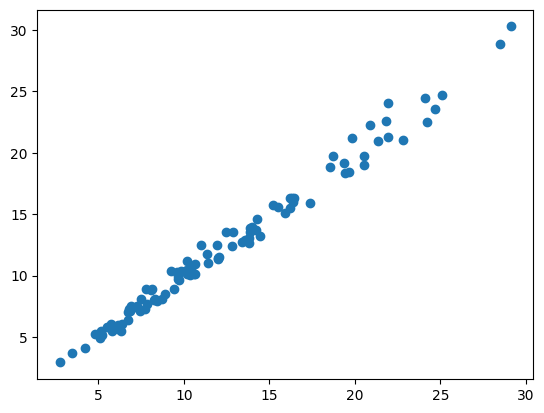

In [27]:
import matplotlib.pyplot as plt
for batch in dataloader:

    x,tok, targets = batch
    x,tok, targets = x.unsqueeze(1).to(device),tok.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs = model(x,tok)
    print(outputs)
    print(targets)
    plt.scatter(targets.cpu().detach().numpy(),outputs.cpu().detach().numpy())
    break

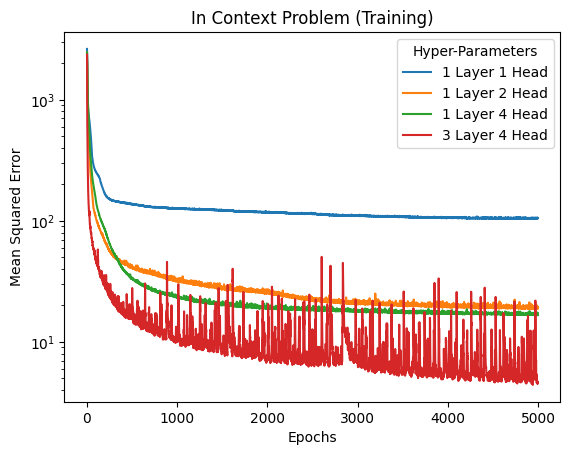

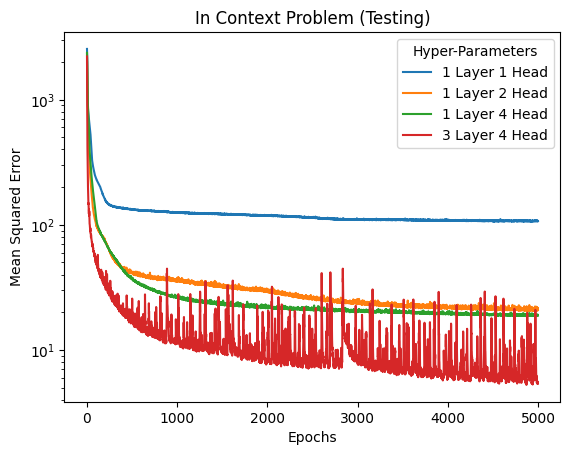

In [138]:
plt.plot(Train1H1LFixed,label=f"1 Layer 1 Head")
plt.plot(Train1H2LFixed,label=f"1 Layer 2 Head")
plt.plot(Train1H4LFixed,label=f"1 Layer 4 Head")
plt.plot(Train3,label=f"3 Layer 4 Head")
plt.title("In Context Problem (Training)")
plt.yscale('log')
plt.ylabel("Mean Squared Error")
plt.xlabel("Epochs")
plt.legend(title="Hyper-Parameters")
plt.savefig("InContextTrain.png")
plt.show()
plt.plot(Test1H1LFixed,label=f"1 Layer 1 Head")
plt.plot(Test1H2LFixed,label=f"1 Layer 2 Head")
plt.plot(Test1H4LFixed,label=f"1 Layer 4 Head")
plt.plot(Test3,label=f"3 Layer 4 Head")
plt.title("In Context Problem (Testing)")
plt.yscale('log')
plt.ylabel("Mean Squared Error")
plt.xlabel("Epochs")
plt.legend(title="Hyper-Parameters")
plt.savefig("InContextTest.png")

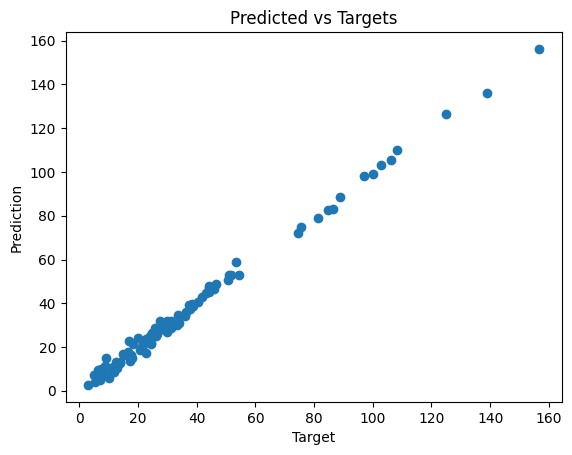

In [139]:
plt.scatter(targets.cpu(),outputs.cpu().detach().numpy())
plt.title("Predicted vs Targets")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.savefig("PvT2.png")